In [1]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv('https://raw.githubusercontent.com/open-covid-19/data/master/output/world.csv')
df['Confirmed'] = df['Confirmed'].astype(float)
df['Deaths'] = df['Deaths'].astype(float)
df = df.set_index('Date')

### Defining our parameters
In this notebook, we are looking at the confirmed and fatal cases for Korea through March 16. To apply the model to other countries or dates, just change the code below.

In [2]:
country_code = 'KR'
date_limit = '2020-03-16'

### Looking at the outbreak
There are months of data, but we only care about when the number of cases started to grow. We define *outbreak* as whenever the number of cases exceeded certain threshold. In this case, we are using 10.

In [3]:
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 10):
    ''' Returns a mask for > N confirmed cases '''
    return data['Confirmed'] > threshold

In [4]:
cols = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']
# Get data only for the selected country
country = df[df['CountryCode'] == country_code][cols]
# Get data only for the selected dates
country = country[country.index <= date_limit]
# Get data only after the outbreak begun
country = country[get_outbreak_mask(country)]

### Plotting the data
Let's take a first look at the data. A visual inspection will typically give us a lot of information.

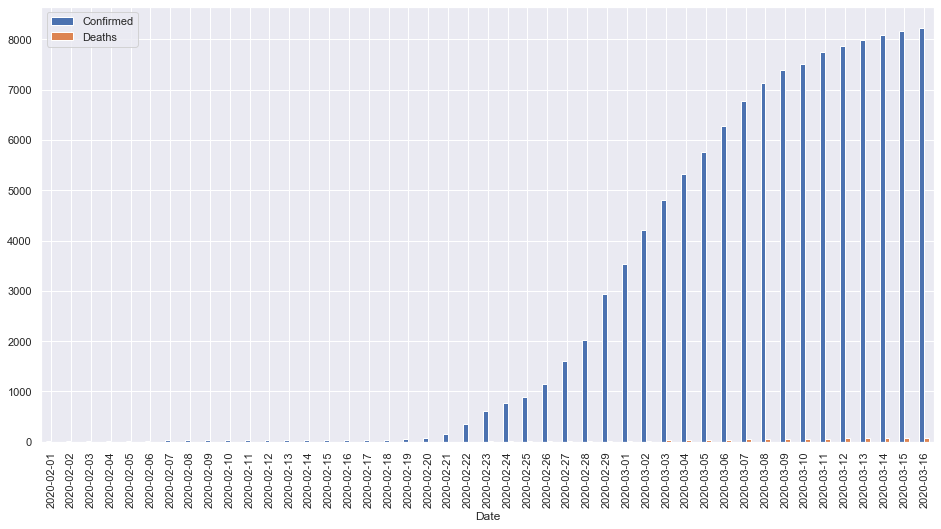

In [5]:
country.plot(kind='bar', figsize=(16, 8));

### Modeling the data
The data appears to follow very closely a sigmoid function (S-shaped curve). Logically, it makes sense: by the time the outbreak is discovered, there are many undiagnosed (and even asymptomatic) cases which lead to very rapid initial growth; later on, after a combination of aggressive measures to avoid further spread and immunity developed by potential hosts, the growth becomes much slower. Let's see if we can model it using some parameter fitting 

In [6]:
import math
import numpy as np
from scipy import optimize

def logistic_function(x: float, a: float, b: float, c: float):
    ''' 1 / (1 + e^-x) '''
    return a / (1.0 + np.exp(-b * (x - c)))

X, y = list(range(len(country))), country['Confirmed'].tolist()
# Providing a reasonable initial guess is crucial for this model
params, _ = optimize.curve_fit(logistic_function, X, y, p0=[max(y), 1, np.median(X)])

print('Estimated function: {0:.3f} / (1 + e^({1:.3f} * (X - {2:.3f}))'.format(*params))

Estimated function: 8188.546 / (1 + e^(0.329 * (X - 30.092))


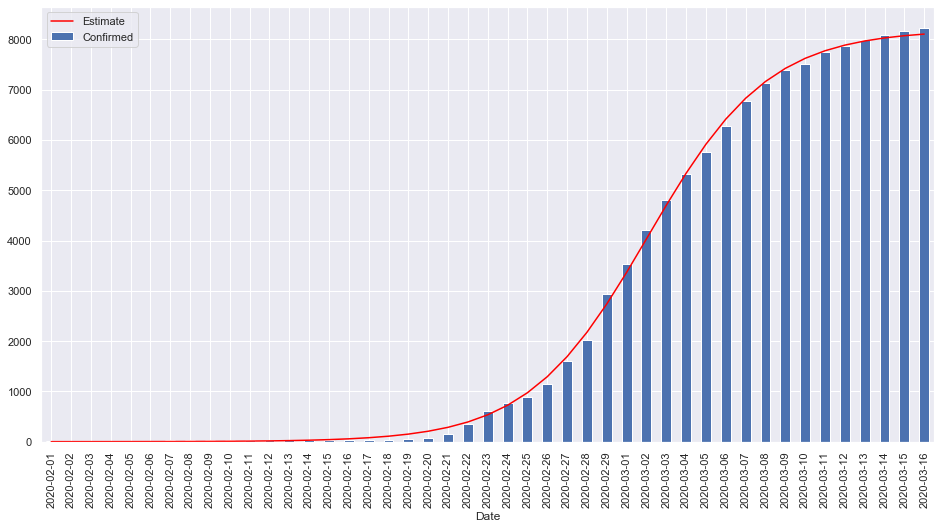

In [7]:
ax = country[['Confirmed']].plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params) for x in X]
ax.plot(country.index, estimate, color='red', label='Estimate')
ax.legend();

### Evaluating the model
That curve looks like a very good fit! Traditional epidemiology models generally capture a number of different parameters representing biology and social factors; however, the COVID-19 pandemic might be very challenging to fit for traditional models for a number of reasons:
* It's a completely new disease, never seen before
* Unprecedented, very aggressive measures have been taken by many nations to try to stop the spread of the disease
* Testing has been held back by a combination of shortage of tests and political reasons

If a known model is not being used, then a simpler model is more likely to be a better fit; too many parameters have a tendency to *overfit* the data which diminishes the model's ability to make predictions. In other words, the model may appear to be able to perfectly follow known data, but when asked to make a prediction about future data it will likely be wrong. This is one of the main reasons why machine learning is not a good tool for this task, since there is not enough data to avoid overfitting a model.

### Validating the model
To validate our model, let's try to fit it again without looking at the last 3 days of data. Then, we can estimate the missing days using our model, and verify if the results still hold by comparing what the model thought was going to happen with the actual data.

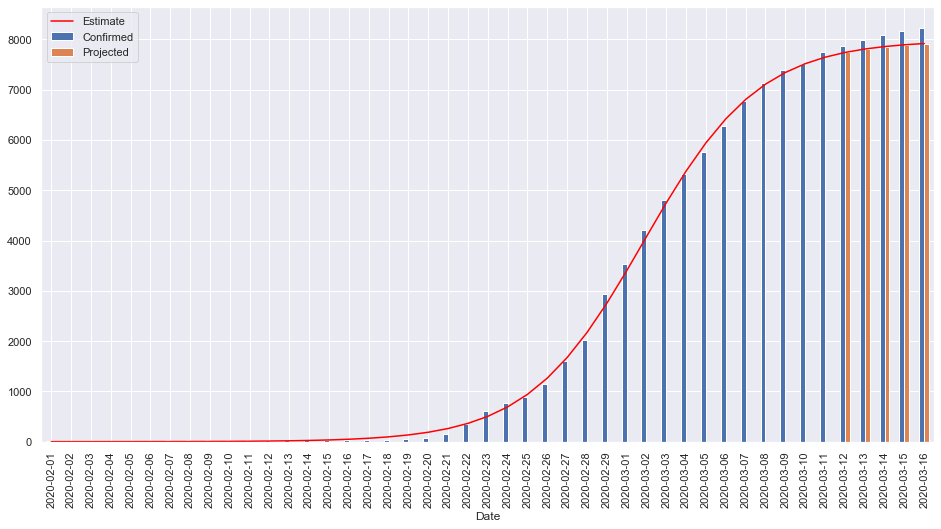

In [8]:
ESTIMATE_DAYS = 5
X_, y_ = X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS]
params_validate, _ = optimize.curve_fit(logistic_function, X_, y_, p0=[max(y), 1, np.median(X)])

# Project zero for all values except for the last ESTIMATE_DAYS
projected = [0] * len(X_) + [logistic_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=country.index, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params_validate) for x in X]
ax.plot(country.index, estimate, color='red', label='Estimate')
ax.legend();

### Projecting future data
It looks like our logistic model slightly underestimates the confirmed cases. This indicates that the model is optimistic about the slowdown of new cases being reported. A number of factors could affect this, like wider availability of tests. 

Ultimately, it is also possible that the logistic model is not an appropriate function to use. However, the predictions are close enough to the real data that this is probably a good starting point for a rough estimate over a short time horizon.

Now, let's use the model we fitted earlier which used all the data, and try to predict what the next 3 days will look like.

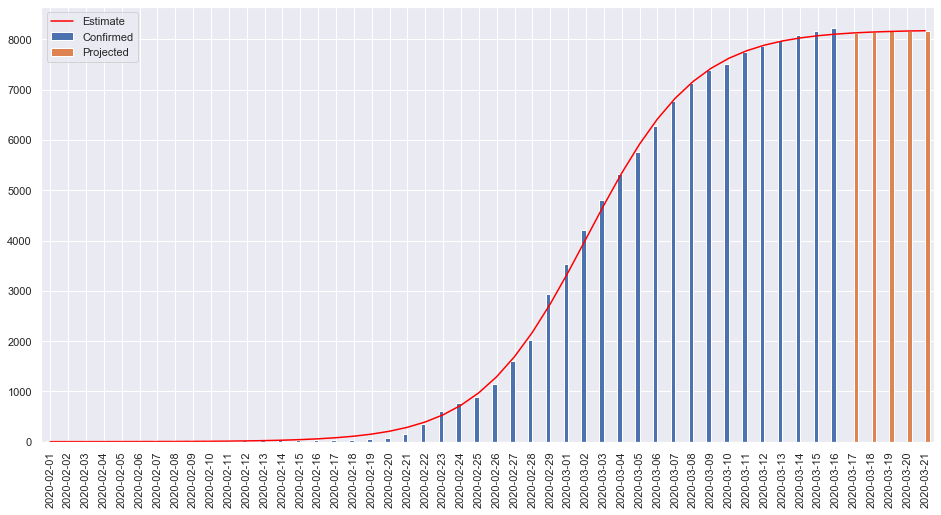

In [9]:
import datetime

FUTURE_DAYS = 5

# Append N new days to our indices
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in country.index]
for _ in range(FUTURE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection with the previously estimated parameters
projected = [0] * len(X) + [logistic_function(x, *params) for x in range(len(X), len(X) + FUTURE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': country['Confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Estimate')
ax.legend();